In [14]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import re
import h5py
import scipy.io as spio
import scipy as sp

import sys
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()
from multiprocessing.dummy import Pool
import scipy.spatial.distance as dst
from scipy.stats import multivariate_normal
import scipy.optimize as op
import scipy as sp
sys.path.append('/home/yves/Documents/')
import twoptb as MP

kernel = lambda x1,x2: k*np.exp((-.5)*((x1-x2)**2)/l**2)

##  Helper Functions from Previous Stuff

In [2]:
def calc_post_unNorm(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):
    
    """ Code essentially copied from implementation by Hooram Nam"""
    
    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)
    
    L1 = np.dot(np.ones(n_neurons*nT),np.exp(A))
    L2 =  ybar.dot(A)
    L3 =  xbar.T.dot(K_bigInv.dot(xbar))
    p = L1 - L2 + L3 
    return p

def calc_post_grad(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):

    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    dL1 = np.dot(np.exp(A),C_big)
    dL2 = np.dot(ybar, C_big)
    dL3 = np.dot(xbar.T,  K_bigInv)

    dL = dL1 - dL2 + dL3

    return np.squeeze(dL)


def calc_post_hess(xbar, ybar, C_big, d, K_bigInv,t,n_neurons):
    
    nT = len(t)

    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    Aexpdiagonal = sp.sparse.spdiags(np.exp(A),0,n_neurons*nT,n_neurons*nT)
    temp = Aexpdiagonal.dot(C_big)

    ddL = np.dot(C_big.T, temp) +  K_bigInv
    return ddL

In [3]:
def CdtoVecCd(C, d):
    '''Given C,d returns vec(C,d).
    Parameters:
    ===========
      * C : numpy array of shape (xdim, ydim), loading matrix
      * d : numpy array of shape (ydim, 1), offset parameter
    Returns:
    ========
      * vecCd : numpy array of shape (xdim*ydim+ydim, 1), vectorized C,d
    '''
    ydim,xdim = np.shape(C)
    matCd = np.concatenate([C.T, np.asarray([d])]).T
    vecCd = np.reshape(matCd.T, xdim*ydim + ydim)
    return vecCd

def vecCdtoCd(vecCd, xdim, ydim):
    '''Given vecCd, xdim, ydim, returns C,d.
    Parameters:
    ===========
      * vecCd : numpy array of shape (xdim*ydim+ydim, 1), vectorized C,d
      * xdim : int, latent dimensionality
      * ydim : int, number of neurons
    
    Returns:
    ========
      * C : numpy array of shape (xdim, ydim), loading matrix
    '''
    matCd = np.reshape(vecCd, [xdim+1, ydim]).T
    C = matCd[:,:xdim]
    d = matCd[:,xdim]
    return C, d

In [4]:
def MStepObservationCost(vecCd, xdim, ydim, y, x_post_mean, postCov):
    '''
    Function written Macke, Buesing, Sahani 2015 for the PLDS model.
    The Observation parameter cost function is identical to the P-GPFA model.
    Translated to Python by Hooram Nam 2015
    '''
    T = nT
    xdim,ydim = nDims,n_neurons
    C,d = vecCdtoCd(vecCd, xdim ,ydim)

    CC = np.zeros([ydim,xdim**2])

    for yd in range(ydim):
        CC[yd,:] = np.reshape(np.outer(C[yd,:],C[yd,:]),xdim**2)

    f = 0
    df = np.zeros(np.shape(C))
    dfd = np.zeros(ydim)

    y = y
    m = x_post_mean
    vsm = np.reshape(postCov,[T,xdim**2])

    hh = (np.dot(C,m) + np.asarray([d]).T)
    rho = (np.dot(CC, vsm.T))
    yhat = np.exp(hh+rho/2)
    f = f + sum(sum(y*hh-yhat))

    return -f

In [5]:
def MStepObservationCost_grad(vecCd, xdim, ydim, y, x_post_mean,post_vsm):
    '''
    Function written Macke, Buesing, Sahani 2015 for the PLDS model.
    The Observation parameter cost function is identical to the P-GPFA model.
    Translated to Python by Hooram Nam 2015
    '''
    T = nT
    xdim,ydim = nDims,n_neurons
    C, d = vecCdtoCd(vecCd, xdim, ydim)

    CC = np.zeros([ydim,xdim**2])

    for yd in range(ydim):
        CC[yd,:] = np.reshape(np.outer(C[yd,:],C[yd,:]),xdim**2)

    dfC = np.zeros(np.shape(C_init))
    dfd = np.zeros(ydim)

    m = x_post_mean
    vsm = np.reshape(post_vsm,[T,xdim**2])

    hh = np.float64(np.dot(C,m) + np.asarray([d]).T)
    rho = np.float64(np.dot(CC, vsm.T))

    yhat = np.exp(hh+rho/2)

    vecC = np.reshape(C.T,xdim*ydim)

    T1 = np.reshape(np.dot(yhat,vsm).T, [xdim, xdim*ydim]).T
    T2 = (T1 * np.asarray([vecC]).T)
    T3 = np.reshape(T2.T,(xdim,xdim,ydim))
    TT = np.sum(T3,1)

    dfC = dfC + np.dot(y-yhat,m.T) - TT.T
    dfd = dfd + np.sum(y-yhat,1)
    
    vecdf = -CdtoVecCd(dfC,dfd)/1

    return vecdf


In [6]:
def get_sqdists(x,y=None):
    
    if type(y)!=np.ndarray:
        if x.ndim==1:
            dists = dst.pdist(np.vstack([x,np.zeros(x.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.pdist(x)
            
        dists = dst.squareform(dists)
        
    else:
        if x.ndim==1:
            dists = dst.cdist(np.vstack([x,np.zeros(x.shape)]).T,np.vstack([y,np.zeros(y.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.cdist(x,y)
    return dists

In [7]:
def calc_K(x,y=None,l=.5,add_offset=1e-3,reshape_params=None):
    
        
    distsSq = get_sqdists(x,y)
    
    cov = (1-add_offset)*np.exp(-.5*distsSq/(l**2)) 
    
    cov += np.eye(len(x))*add_offset
    return cov

In [8]:
def make_Cbig(C,t):
    return np.kron(np.eye(len(t)),C)

In [9]:
def make_Kbig(params,t,nDims,epsNoise=1e-3):

    epsSignal = (1-epsNoise)
    nT = len(t)  #number of time points
    #nDims = params['C'].shape[1] #dimensionality of the latent space
    #nT is
    K_big = np.zeros([nT*nDims,nT*nDims])  
    R_big = np.zeros([nT*nDims,nT*nDims]) 

    for dim in range(nDims):

        for t1_idx,t1 in enumerate(t):

            for t2_idx,t2 in enumerate(t):

                K_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = epsSignal*np.exp((-0.5)*((t1-t2)**2/(params['l'][dim])**2))
                R_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = 1
    return K_big, R_big


#  Ok now lets generate Poisson Data

In [10]:
n_neurons = 155 #q
nDims = 13#
n_timePoints = 67
t = np.linspace(-33,33,num=n_timePoints)/10 #use this for an unmarked time series
nT = len(t)

sigmaN = 1e-3
sigmaF = [1-sigmaN for i in range(nDims)]



C = np.random.normal(loc=0,scale=.5,size=(n_neurons,nDims))/2
d = np.random.randint(0,6,size=(n_neurons))/2



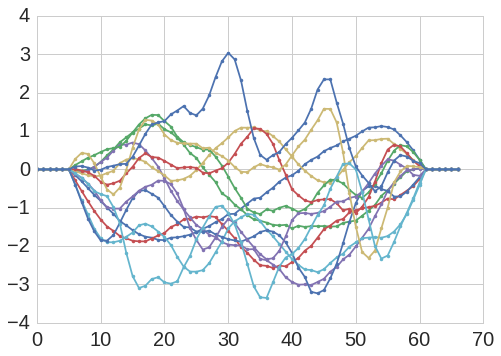

In [11]:
x = np.zeros([nDims,nT])

length_scales_GP = [10**(.3 if i== 0 else -i*.05) for i in range(nDims)]
params = {
          'l':length_scales_GP
         }
#params = [[4,1,2e0],
#          [1,2,1.5e-1],
#          [6,3,1e0]]

for i,l in enumerate(length_scales_GP):
    
    Ki = calc_K(x=t,y=t,l=l)
    Ki /= np.max(Ki)
    mvn1 = multivariate_normal(mean=[np.random.randint(1,7)-3]*n_timePoints,cov=Ki)
    x[i] =  mvn1.rvs()*np.concatenate([np.zeros(5),np.cos(np.linspace(-np.pi/2,0,num=15)),np.ones(nT-35),np.cos(np.linspace(0,.5*np.pi,num=10)),np.zeros(5)])

for i in range(nDims):
    plt.plot(x[i],'.-')
    
#this is the observed data, which we pretend are the spike trains
rate_params = np.exp(C.dot(x) + d[:,None])
y = np.random.poisson(rate_params + np.abs(np.random.normal(loc=0,scale=1,size=rate_params.shape)))

In [12]:
true_params = {'C': C,
          'd': d,
          'l': length_scales_GP}

In [54]:
st = time.time()
ybar = np.array([y.T.flatten()])

xSt = []
CdSt = []
Cst = []
dSt = []
#C_init = np.random.normal(size = C.shape)
#d_init = np.random.normal(size =d.shape)
#xInit = np.random.normal(size = x.shape)

nT = len(t)
nDims = true_params['C'].shape[1]


C_init = np.random.normal(size = (n_neurons,nDims))
d_init = np.random.normal(size =n_neurons)
xInit = np.random.normal(size = (nDims,nT))

nDims = C_init.shape[1]


covSt = []
xSt.append(xInit); Cst.append(C_init); dSt.append(d_init)
K_big,_ = make_Kbig(params,t,nDims,epsNoise=1e-3)
K_bigInv = np.linalg.inv(K_big+ np.eye(K_big.shape[0])*1e-3)
C_big = make_Cbig(Cst[-1],t)
xbar = np.array([xSt[-1].T.flatten()]).T

maxEMiter = 500

for i in range(500):
    print i,
    ########################################################################
    ##############               E-Step                     ################
    ########################################################################
    
    K_big,_ = make_Kbig(params,t,nDims,epsNoise=1e-3)
    C_big = make_Cbig(Cst[-1],t)

    resLap = op.minimize(
        fun = calc_post_unNorm,
        x0 = xSt[-1],
        method='Newton-CG',
        args = (ybar, C_big, d, K_bigInv,t,n_neurons),
        jac = calc_post_grad,
        hess = calc_post_hess,
        options = {'disp': False,'maxiter': 10000,'xtol':1e-16
        })


    x_post_mean = resLap.x.reshape(nDims,nT,order='F')
    xSt.append(x_post_mean)
    xbar = np.array([xSt[-1].T.flatten()]).T


    hess = calc_post_hess(resLap.x,  ybar, C_big, d, K_bigInv,t,n_neurons)
    PostCovGP = np.linalg.inv(hess)
    covSt.append(PostCovGP)
    #PostCovGP = PostCovGP



    temp_vsm = np.zeros([nT,nDims,nDims])
    for kk in range(nT):
        temp_vsm[kk][:,:] = PostCovGP[kk::nT,kk::nT]


    ########################################################################
    ##############               M-Step                     ################
    ########################################################################

    vecCd = CdtoVecCd(Cst[-1], dSt[-1])
    #xinit = np.random.normal(size=(xdim*ydim+ydim))#np.zeros(xdim*ydim+ydim)
    #xinit = vecCd + np.random.normal(size=(xdim*ydim+ydim))
    T = nT


    resCd = op.minimize(
                    fun = MStepObservationCost,
                    x0 = vecCd,
                    args = (nDims, n_neurons, y, xSt[-1], temp_vsm),
                    jac = MStepObservationCost_grad,
                    method = 'TNC',
                    options = {'disp': False, 'maxiter':4000,'ftol':1e-16,'gtol':1e-16,'xtol':1e-16}
                    )


    C_inf,D_inf = vecCdtoCd(resCd.x, nDims, n_neurons)
    Cst.append(C_inf); dSt.append(D_inf)
print time.time() - st

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [1]:
4579.9543252/60

76.33257208666667

# Plotting

In [2]:
U,D,V = sp.linalg.svd(Cst[-1])
xSVD = (np.dot(np.diag(D),V.T).dot(xSt[-1]))

NameError: name 'sp' is not defined

In [57]:
U,D,V = sp.linalg.svd(C)
xSVD_true = (np.dot(np.diag(D),V.T).dot(x))

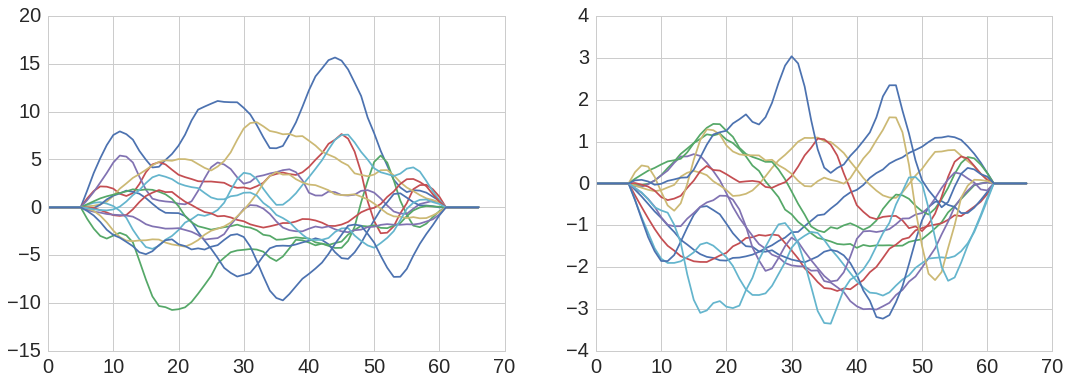

In [58]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
for i in xSVD_true:
    plt.plot(i)
    
plt.subplot(1,2,2)
for i in x:
    plt.plot(i)
    

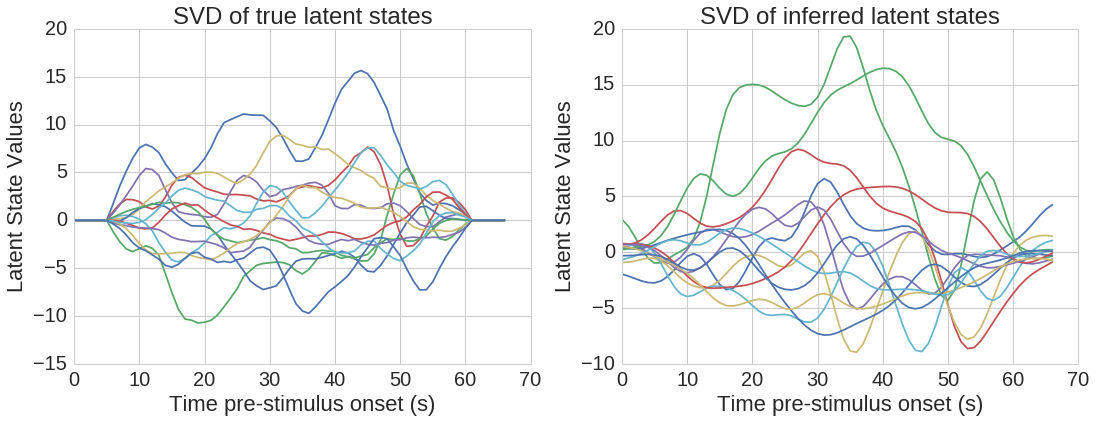

In [59]:
## Plot the SVD of the inferred and ground truth latent state trajectories
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.title('SVD of true latent states')
for i in xSVD_true:
    plt.plot(i)
    plt.xlabel('Time pre-stimulus onset (s)')
    plt.ylabel('Latent State Values')
    
    
plt.subplot(1,2,2)
plt.title('SVD of inferred latent states')
for i in xSVD:
    plt.plot(i)
    plt.xlabel('Time pre-stimulus onset (s)')
    plt.ylabel('Latent State Values')

    

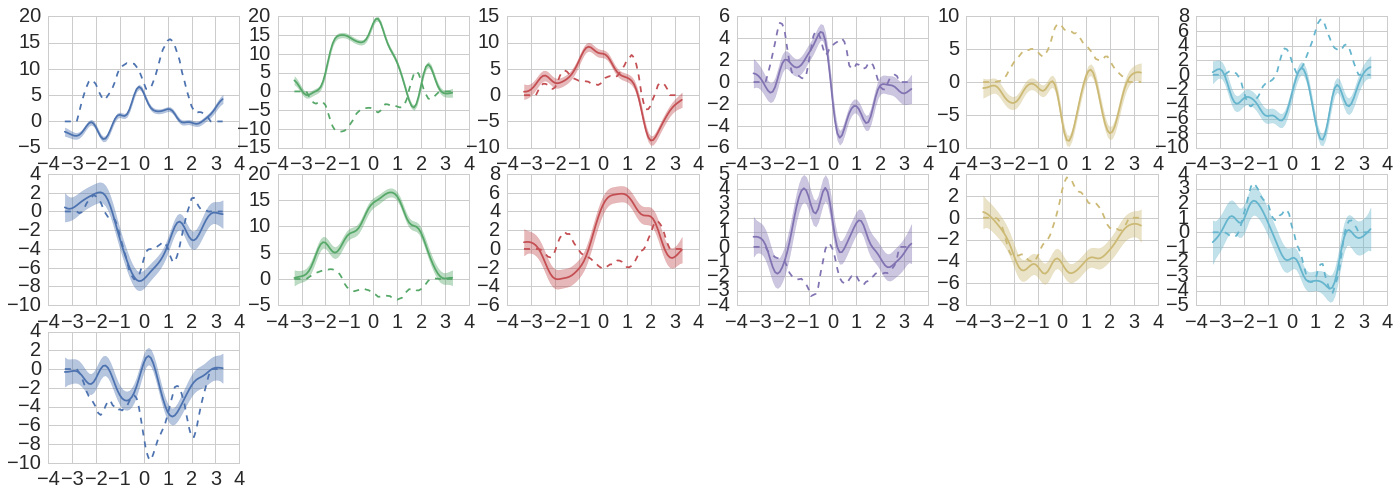

In [60]:
plt.figure(figsize=(24,8))
clrs = seaborn.color_palette('deep',n_colors=nDims,desat=1)#seaborn.color_palette('RdBu',n_colors=3)

i = 0
for lapInf,gT in zip(xSVD,xSVD_true):
    plt.subplot(3,6,i+1)    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    


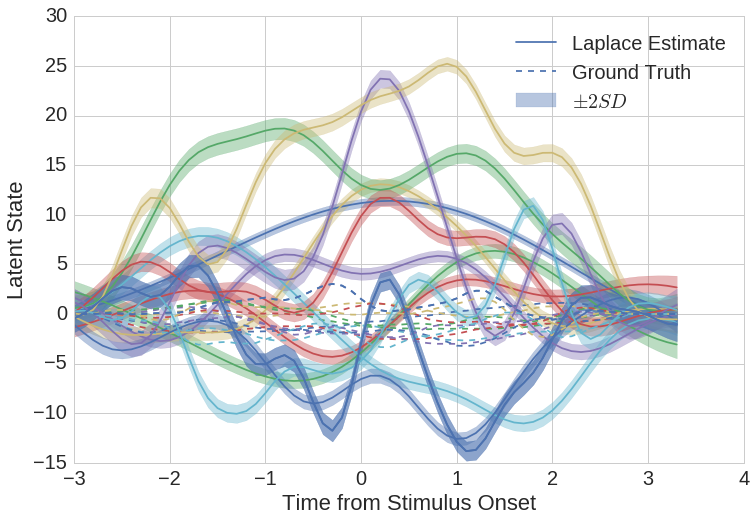

In [61]:
plt.figure(figsize=(12,8))
clrs = seaborn.color_palette('deep',n_colors=nDims+1,desat=1)#seaborn.color_palette('RdBu',n_colors=3)
SD2 = 3*np.sqrt(PostCovGP.diagonal().reshape(nDims,nT,order='F'))
i = 0
for lapInf,gT in zip(xSt[-1],x):
    
    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    
plt.plot(t,lapInf,color=clrs[i-1],label='Laplace Estimate')
plt.plot(t,gT,linestyle='--',color=clrs[i-1],label='Ground Truth')
plt.fill_between(t,lapInf + SD2[i-1],lapInf - SD2[i-1],color=clrs[i-1],alpha=.4,label=r'$\pm2SD$')

plt.ylabel('Latent State')
plt.xlabel('Time from Stimulus Onset')
plt.xlim(-3,)
plt.legend(loc='best')

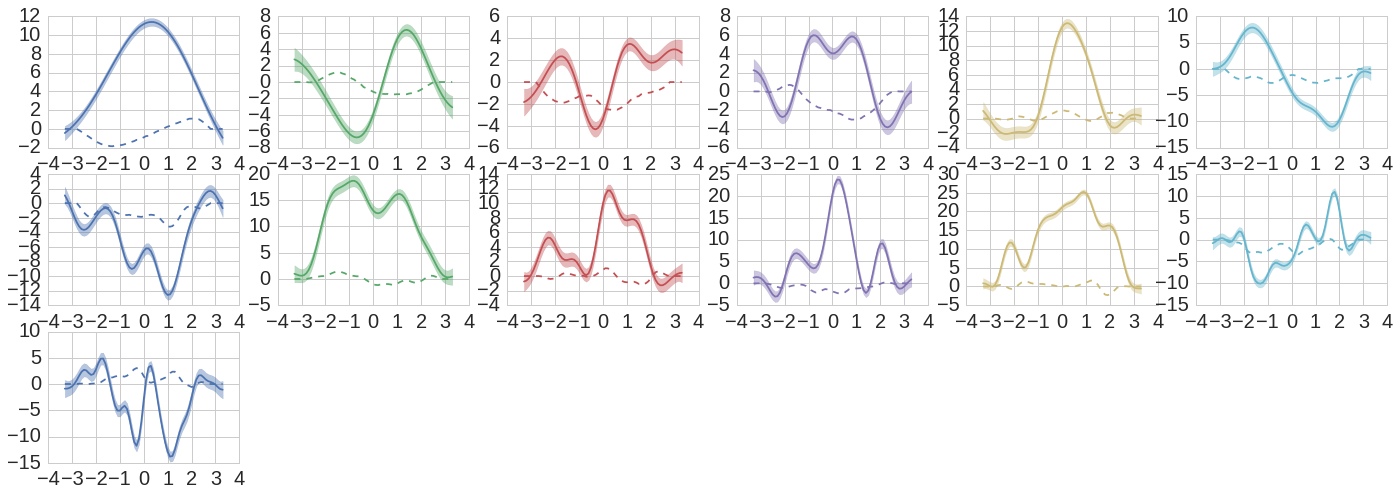

In [62]:
plt.figure(figsize=(24,8))
clrs = seaborn.color_palette('deep',n_colors=nDims,desat=1)#seaborn.color_palette('RdBu',n_colors=3)

i = 0
for lapInf,gT in zip(xSt[-1],x):
    plt.subplot(3,6,i+1)    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    


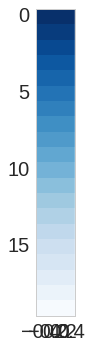

In [95]:
plt.imshow(np.flipud(np.array([range(20)]).T),aspect=.4,interpolation='None',cmap='Blues')
plt.grid()

In [123]:
np.linspace(maxEMiter,-maxEMiter/10,num=12)

array([ 500.,  450.,  400.,  350.,  300.,  250.,  200.,  150.,  100.,
         50.,    0.,  -50.])

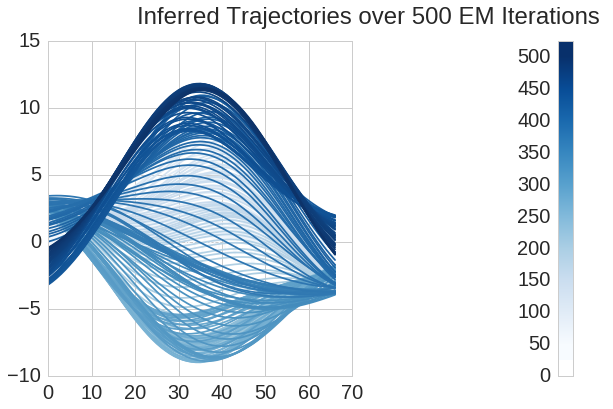

In [126]:
clrs = seaborn.color_palette('Blues',n_colors=int(2+len(xSt)/2),desat=.9)
plt.figure(figsize=(12,6))
plt.suptitle('Inferred Trajectories over %s EM Iterations \n' %maxEMiter)

plt.subplot(1,2,1)
for  i,xs in enumerate(xSt[0::2]):
    plt.plot(xs[0],color=clrs[i],alpha=1)
    
plt.subplot(1,2,2)
plt.imshow(np.flipud(np.array([range(10)]).T),aspect=2,cmap='Blues')
plt.xticks([])
plt.yticks(np.linspace(0,10,num=11),np.linspace(maxEMiter,0,num=11).astype('int'))
plt.grid()

## Plot Firing Rates

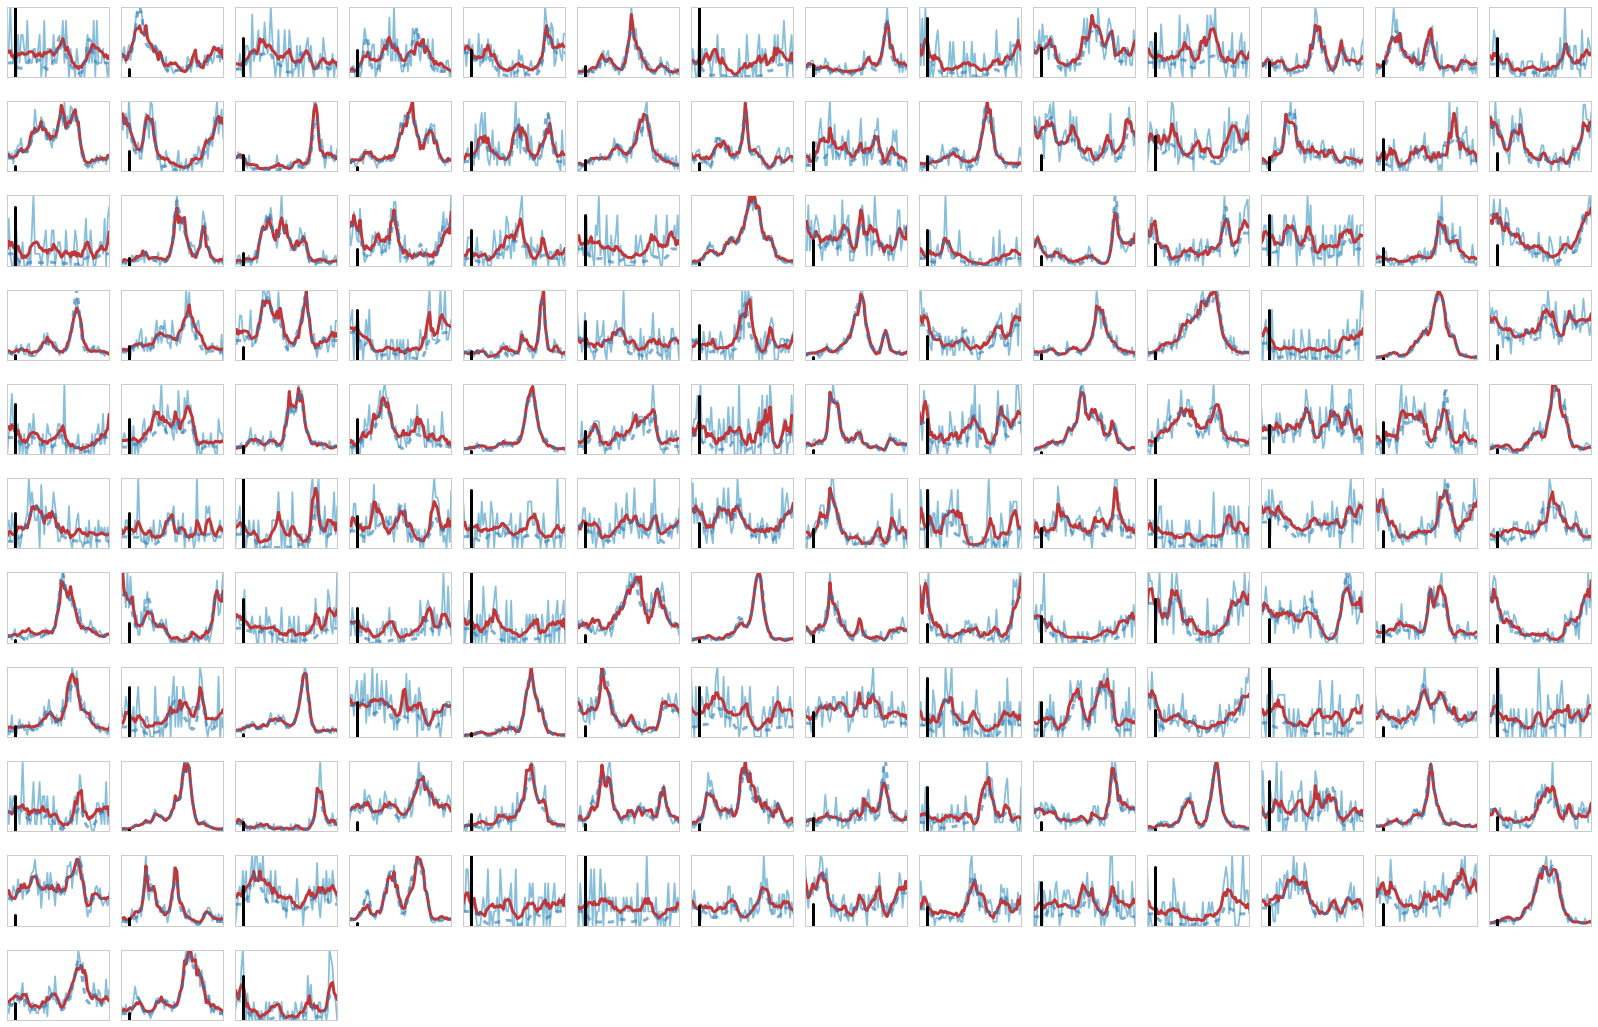

In [66]:
plt.figure(figsize=(22,18))
clrs = seaborn.color_palette('RdBu',n_colors=6)
#plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= np.ceil(np.sqrt(n_neurons))+1,np.ceil(np.sqrt(n_neurons))+1

tt = 0

idx = 1
for real,sim in zip(np.exp(C.dot(x).T+d).T,
                    np.exp(Cst[idx].dot(xSt[idx]).T+dSt[idx]).T):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[tt],color=clrs[-2])

        plt.plot(sim,color=clrs[0],linewidth=3)
        plt.plot(real,'--',color=clrs[-1],linewidth=3,alpha=0.6)

        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        plt.plot([5,5],[0,5],linewidth=3,color='k')
        #plt.legend()
        
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)


## Plot Some Real and Smoothing out spike Rates

In [ ]:
newN = n.T.reshape(-1,67,order='F')
plt.figure(figsize=(32,18))
clrs = seaborn.color_palette('RdBu',n_colors=6)
plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= 12,12

tt = 0
for real,sim in zip(rate_params,np.exp(C.dot(x_post_mean).T+d).T):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[tt],color=clrs[-2])

        plt.plot(real,color=clrs[0],linewidth=3,alpha=0.6)
        plt.plot(sim,color=clrs[-1],linewidth=3)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        #plt.legend()
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)


#  Now Perform the M-step

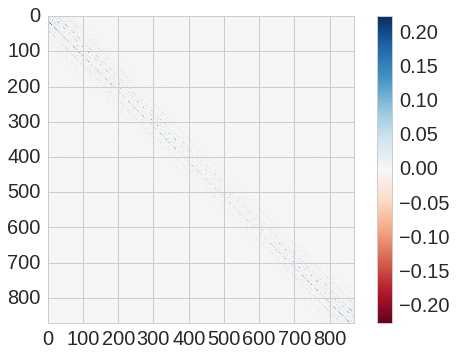

In [39]:
plt.imshow(PostCovGP,vmin=-np.max(PostCovGP),vmax=np.max(PostCovGP),interpolation='None',cmap='RdBu')
#plt.ylim(100,0)
#plt.xlim(0,100)
plt.colorbar()

In [1423]:
C.dot(x_post_mean[:,ti]) + d

array([-0.07053585,  1.4604385 ,  1.11829414,  0.45240156,  2.11791852,
        1.54290578,  1.54070466, -0.01301732,  2.13630196,  2.50285959,
        0.48592169,  2.56463289,  1.51696681,  1.42948271,  1.03488168,
        1.90198625,  1.94917623,  0.94920518,  2.04519836,  0.52657854,
        1.08810488,  2.08907154,  2.14338291,  1.50619104,  0.548503  ,
        0.4892585 ,  2.04097646,  2.05657157,  2.08281018,  1.47796913,
        1.45385434,  0.56115555,  2.45748127,  2.53991706,  0.49339685,
        2.00722664,  1.54186396,  2.49575618,  2.49251764,  1.65614446,
        0.92395737,  2.0360378 ,  1.63173102,  2.4997502 ,  0.6445266 ,
        2.17250862,  1.09201525,  1.95124339,  0.95498994,  0.47254881,
        0.93097412,  0.44341043,  2.10580078,  2.57146911,  0.95289209,
        0.90482528,  2.52573722,  0.95013857, -0.06714867,  2.54254612,
        1.49939858,  0.45609478,  0.94089078,  0.12059871,  0.35292829,
        1.39607819,  0.5270361 ,  2.06594483,  0.86608249,  0.07

In [1270]:
        covT = PostCovGP[ti*nDims:(ti+1)*nDims,ti*nDims:(ti+1)*nDims]


In [1271]:
PostCovGP.shape

(335, 335)

In [1272]:
C.shape

(80, 5)

In [1273]:
C_tt =C.dot(x_post_mean)

In [1274]:
def calc_obs_LL(C,d,nDims,nT,PostCovGP,n_neurons,x_post_mean,y):
    C = C.reshape(n_neurons,nDims)
    LL = 0
    for ti in range(nT):
        covT = PostCovGP[ti*nDims:(ti+1)*nDims,ti*nDims:(ti+1)*nDims]
        t1 = y[:,ti].dot(  C.dot(x_post_mean[:,ti]) + d  + .5*np.diag(C.dot(covT).dot(C.T)))
        t2 = C.dot(x_post_mean[:,ti]) + d 
        t3 = np.ones(n_neurons).dot(np.exp(t2))
        LL += t1 - t3
    return LL

In [1275]:
##Here calculate grad_C
def calc_grad_C(C,d,nDims,nT,PostCovGP,n_neurons,x_post_mean,y):
    C = C.reshape(n_neurons,nDims)
    grad = np.zeros(C.shape)
    for ti in range(nT):
        covT = PostCovGP[ti*nDims:(ti+1)*nDims,ti*nDims:(ti+1)*nDims]

        t1 = np.array([y[:,ti]]).T.dot(np.array([x_post_mean[:,ti]]))

        t2 = np.diag(np.exp((C.dot(x_post_mean[:,ti]) + d + (1/2)*np.diag(C.dot(covT).dot(C.T)))))
        t3 = np.ones([1,n_neurons]).T.dot(np.array([x_post_mean[:,ti]])) + C.dot(covT)
        grad += t1 - t2.dot(t3)
        return grad


In [1276]:
C_init = np.zeros(C.shape)#C_inf#np.random.normal(size=C.shape)

In [1277]:
resCd = op.minimize(
        fun = calc_obs_LL,
        x0 = C_init,
        args = (d,nDims,nT,PostCovGP,n_neurons,x_post_mean,y),
        jac = calc_grad_C,
        #method = 'TNC',
        method='Nelder-Mead',
        options = {'disp': False, 'maxiter':5000})

KeyboardInterrupt: 

In [ ]:
C_inf = resCd.x.reshape([n_neurons,nDims],order='C')

In [ ]:
C.shape

In [ ]:
print resCd.success

In [ ]:
plt.figure(figsize=(22,18))
clrs = seaborn.color_palette('RdBu',n_colors=6)
#plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= np.ceil(np.sqrt(n_neurons))+1,np.ceil(np.sqrt(n_neurons))+1

tt = 0
for real,sim in zip(np.exp(C.dot(x_post_mean).T+d).T,
                    np.exp(C_inf.dot(x_post_mean).T+d).T):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[tt],color=clrs[-2])

        plt.plot(sim,color=clrs[0],linewidth=3)
        plt.plot(real,'--',color=clrs[-1],linewidth=3,alpha=0.6)

        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        #plt.legend()
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)


In [ ]:
plt.imshow(C_inf.reshape(n_neurons,nDims),aspect='auto',interpolation='None')

In [ ]:
plt.imshow(PostCovGP,interpolation='None')
plt.colorbar()
plt.grid()

In [1560]:
def CdtoVecCd(C, d):
    '''Given C,d returns vec(C,d).
    Parameters:
    ===========
      * C : numpy array of shape (xdim, ydim), loading matrix
      * d : numpy array of shape (ydim, 1), offset parameter
    Returns:
    ========
      * vecCd : numpy array of shape (xdim*ydim+ydim, 1), vectorized C,d
    '''
    ydim,xdim = np.shape(C)
    matCd = np.concatenate([C.T, np.asarray([d])]).T
    vecCd = np.reshape(matCd.T, xdim*ydim + ydim)
    return vecCd

def vecCdtoCd(vecCd, xdim, ydim):
    '''Given vecCd, xdim, ydim, returns C,d.
    Parameters:
    ===========
      * vecCd : numpy array of shape (xdim*ydim+ydim, 1), vectorized C,d
      * xdim : int, latent dimensionality
      * ydim : int, number of neurons
    
    Returns:
    ========
      * C : numpy array of shape (xdim, ydim), loading matrix
    '''
    matCd = np.reshape(vecCd, [xdim+1, ydim]).T
    C = matCd[:,:xdim]
    d = matCd[:,xdim]
    return C, d

In [1561]:
def MStepObservationCost_grad(vecCd, xdim, ydim, y, x_post_mean,post_vsm):
    '''
    Function written Macke, Buesing, Sahani 2015 for the PLDS model.
    The Observation parameter cost function is identical to the P-GPFA model.
    Translated to Python by Hooram Nam 2015
    '''
    T = nT
    C, d = vecCdtoCd(vecCd, xdim, ydim)

    CC = np.zeros([ydim,xdim**2])

    for yd in range(ydim):
        CC[yd,:] = np.reshape(np.outer(C[yd,:],C[yd,:]),xdim**2)

    dfC = np.zeros(np.shape(C))
    dfd = np.zeros(ydim)

    m = x_post_mean
    vsm = np.reshape(post_vsm,[T,xdim**2])

    hh = np.float64(np.dot(C,m) + np.asarray([d]).T)
    rho = np.float64(np.dot(CC, vsm.T))

    yhat = np.exp(hh+rho/2)

    vecC = np.reshape(C.T,xdim*ydim)

    T1 = np.reshape(np.dot(yhat,vsm).T, [xdim, xdim*ydim]).T
    T2 = (T1 * np.asarray([vecC]).T)
    T3 = np.reshape(T2.T,(xdim,xdim,ydim))
    TT = np.sum(T3,1)

    dfC = dfC + np.dot(y-yhat,m.T) - TT.T
    dfd = dfd + np.sum(y-yhat,1)
    
    vecdf = -CdtoVecCd(dfC,dfd)/1

    return vecdf


In [1562]:
def MStepObservationCost(vecCd, xdim, ydim, y, x_post_mean, postCov):
    '''
    Function written Macke, Buesing, Sahani 2015 for the PLDS model.
    The Observation parameter cost function is identical to the P-GPFA model.
    Translated to Python by Hooram Nam 2015
    '''
    T = nT
    C,d = vecCdtoCd(vecCd, xdim ,ydim)

    CC = np.zeros([ydim,xdim**2])

    for yd in range(ydim):
        CC[yd,:] = np.reshape(np.outer(C[yd,:],C[yd,:]),xdim**2)

    f = 0
    df = np.zeros(np.shape(C))
    dfd = np.zeros(ydim)

    y = y
    m = x_post_mean
    vsm = np.reshape(postCov,[T,xdim**2])

    hh = (np.dot(C,m) + np.asarray([d]).T)
    rho = (np.dot(CC, vsm.T))
    yhat = np.exp(hh+rho/2)
    f = f + sum(sum(y*hh-yhat))

    return -f

In [1563]:
C.shape

(143, 11)

In [1564]:
vecCd.shape

(1716,)

In [1565]:
[ydim,xdim] = np.shape(C)
vecCd = CdtoVecCd(C, d)
xinit = np.random.normal(size=(xdim*ydim+ydim))#np.zeros(xdim*ydim+ydim)
#xinit = vecCd + np.random.normal(size=(xdim*ydim+ydim))
T = nT

In [1566]:

temp_vsm = np.zeros([T,xdim,xdim])
for kk in range(T):
    temp_vsm[kk][:,:] = PostCovGP[kk::T,kk::T]


In [1567]:
resCd = op.minimize(
    fun = MStepObservationCost,
    x0 = xinit,
    args = (xdim, ydim, y, x_post_mean, temp_vsm),
    jac = MStepObservationCost_grad,
    method = 'TNC',
    options = {'disp': False, 'maxiter':4000,'ftol':1e-16,'gtol':1e-16,'xtol':1e-16}
    )

In [1568]:
print resCd.success

True


In [1569]:
C_inf,D_inf = vecCdtoCd(resCd.x, xdim, ydim)

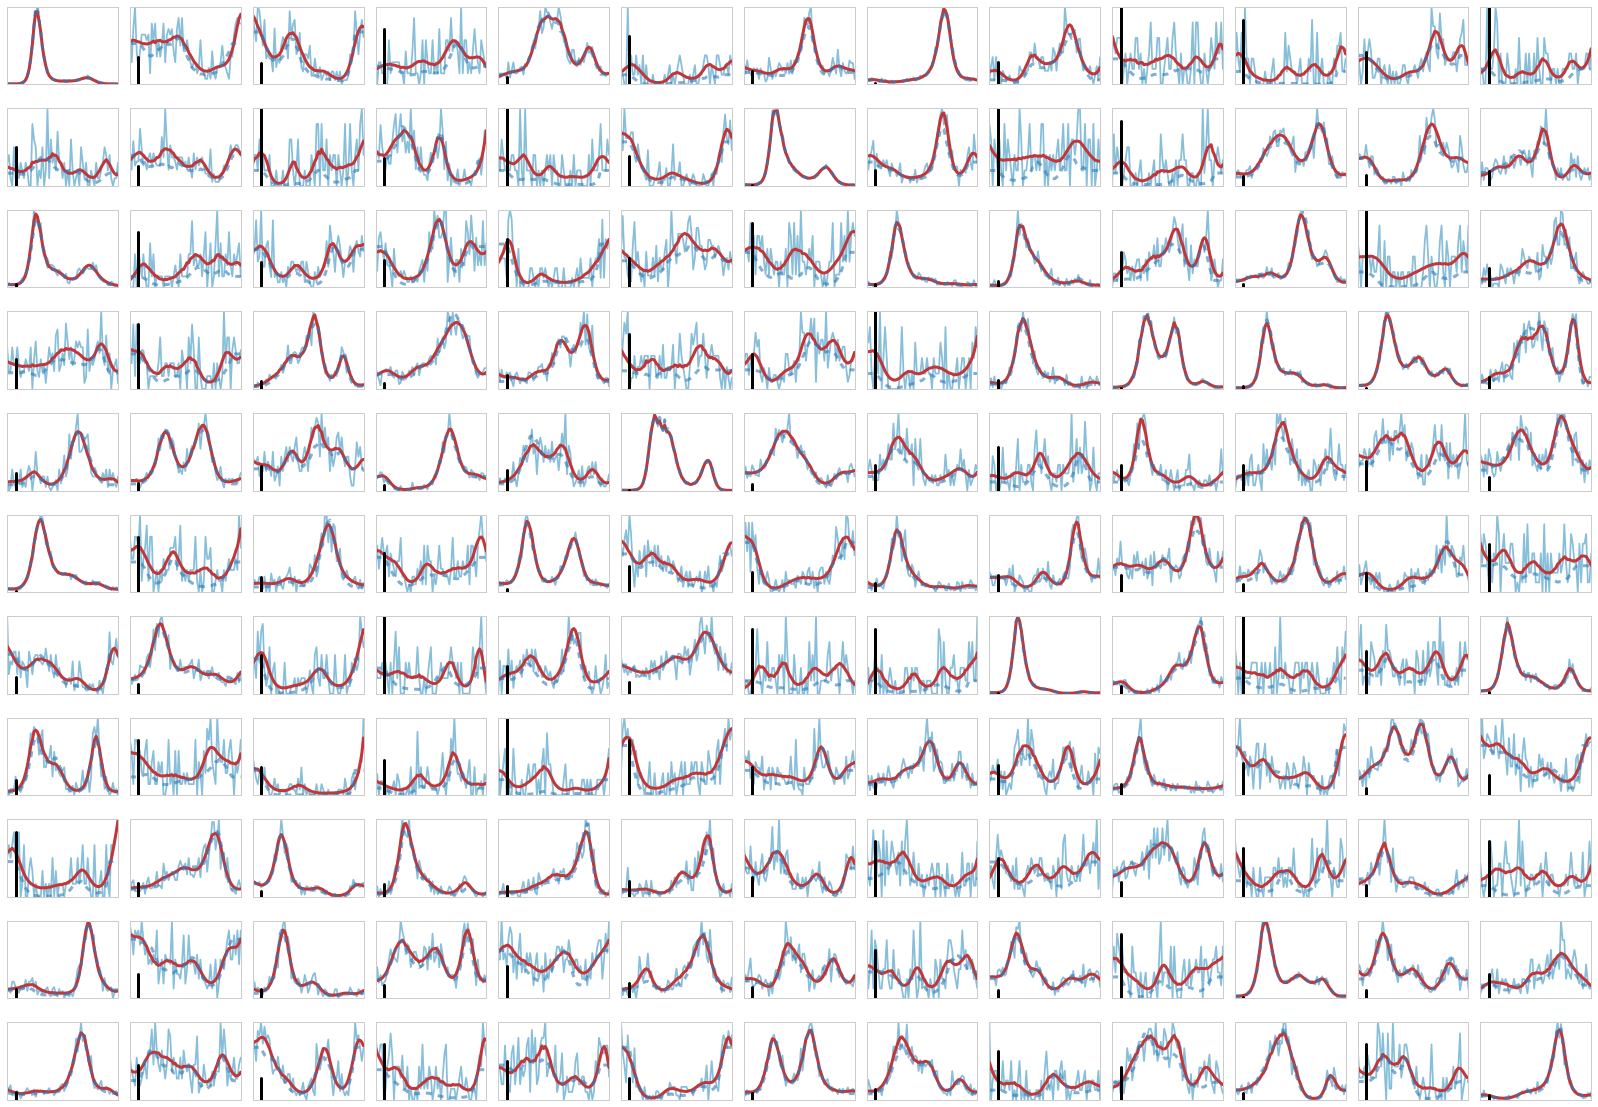

In [1570]:
plt.figure(figsize=(22,18))
clrs = seaborn.color_palette('RdBu',n_colors=6)
#plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= np.ceil(np.sqrt(n_neurons))+1,np.ceil(np.sqrt(n_neurons))+1

tt = 0
for real,sim in zip(np.exp(C.dot(x).T+d).T,
                    np.exp(C_inf.dot(x_post_mean).T+D_inf).T):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[tt],color=clrs[-2])

        plt.plot(sim,color=clrs[0],linewidth=3)
        plt.plot(real,'--',color=clrs[-1],linewidth=3,alpha=0.6)

        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        plt.plot([5,5],[0,5],linewidth=3,color='k')
        #plt.legend()
        
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)


In [ ]:

def MStepObservationCost(vecCd, xdim, ydim, experiment, infRes):
    '''
    Function written Macke, Buesing, Sahani 2015 for the PLDS model.
    The Observation parameter cost function is identical to the P-GPFA model.
    Translated to Python by Hooram Nam 2015
    '''
    T = experiment.T
    numTrials = len(experiment.data)
    C,d = util.vecCdtoCd(vecCd, xdim ,ydim)

    CC = np.zeros([ydim,xdim**2])

    for yd in range(ydim):
        CC[yd,:] = np.reshape(np.outer(C[yd,:],C[yd,:]),xdim**2)

    f = 0
    df = np.zeros(np.shape(C))
    dfd = np.zeros(ydim)

    for trial in range(numTrials):
        y = experiment.data[trial]['Y']
        m = infRes['post_mean'][trial]
        vsm = np.reshape(infRes['post_vsm'][trial],[T,xdim**2])

        hh = (np.dot(C,m) + np.asarray([d]).T)
        rho = (np.dot(CC, vsm.T))
        yhat = np.exp(hh+rho/2)
        f = f + sum(sum(y*hh-yhat))

    return -f/numTrials

def MStepObservationCost_grad(vecCd, xdim, ydim, experiment, infRes):
    '''
    Function written Macke, Buesing, Sahani 2015 for the PLDS model.
    The Observation parameter cost function is identical to the P-GPFA model.
    Translated to Python by Hooram Nam 2015
    '''
    T = experiment.T
    numTrials = len(experiment.data)
    C, d = util.vecCdtoCd(vecCd, xdim, ydim)

    CC = np.zeros([ydim,xdim**2])

    for yd in range(ydim):
        CC[yd,:] = np.reshape(np.outer(C[yd,:],C[yd,:]),xdim**2)

    dfC = np.zeros(np.shape(C))
    dfd = np.zeros(ydim)

    for trial in range(numTrials):
        y = experiment.data[trial]['Y']
        m = infRes['post_mean'][trial]
        vsm = np.reshape(infRes['post_vsm'][trial],[T,xdim**2])

        hh = np.float64(np.dot(C,m) + np.asarray([d]).T)
        rho = np.float64(np.dot(CC, vsm.T))

        yhat = np.exp(hh+rho/2)

        vecC = np.reshape(C.T,xdim*ydim)

        T1 = np.reshape(np.dot(yhat,vsm).T, [xdim, xdim*ydim]).T
        T2 = (T1 * np.asarray([vecC]).T)
        T3 = np.reshape(T2.T,(xdim,xdim,ydim))
        TT = np.sum(T3,1)

        dfC = dfC + np.dot(y-yhat,m.T) - TT.T
        dfd = dfd + np.sum(y-yhat,1)
    
    vecdf = -util.CdtoVecCd(dfC,dfd)/numTrials

    return vecdf

def learnLTparams(oldParams, infRes, experiment, CdOptimMethod, CdMaxIter=None, verbose = False):
    
    [ydim,xdim] = np.shape(oldParams['C'])
    vecCd = util.CdtoVecCd(oldParams['C'], oldParams['d'])
    xinit = np.zeros(xdim*ydim+ydim)
    xinit = vecCd

    if False:
        invPriorCov = np.diag(np.zeros(xdim*ydim+ydim))
        invPriorCov = np.diag(np.ones(xdim*ydim+ydim))
        def cost_prior(vecCd): 
            cost = MStepObservationCostWithPrior(
                vecCd, oldParams, xdim, ydim, experiment, infRes,invPriorCov)
            return cost
        def cost_prior_grad(vecCd): 
            grad = MStepObservationCostWithPrior_grad(
                vecCd, oldParams, xdim, ydim, experiment, infRes, invPriorCov)
            return grad

        obsGradCheck = op.check_grad(MStepObservationCost, MStepObservationCost_grad, vecCd, xdim, ydim, experiment, infRes)
        print('observation grad check = ' + str(obsGradCheck))
        apprxGrad = op.approx_fprime(xinit,MStepObservationCost,1e-8*np.ones(xdim*ydim+ydim), xdim, ydim, experiment, infRes)
        calcdGrad = MStepObservationCost_grad(xinit,xdim, ydim, experiment, infRes)
        plt.plot(apprxGrad,linewidth = 10, color = 'k', alpha = 0.4)
        plt.plot(calcdGrad,linewidth = 2, color = 'k', alpha = 0.4)
        plt.legend(['approximated','calculated'])
        plt.title('Approx. vs. calculated Grad of C,d learning cost')
        plt.tight_layout()
        plt.show()
        pdb.set_trace()
    
    resCd = op.minimize(
        fun = MStepObservationCost,
        x0 = xinit,
        args = (xdim, ydim, experiment, infRes),
        jac = MStepObservationCost_grad,
        method = CdOptimMethod,
        options = {'disp': verbose, 'maxiter':CdMaxIter}